In [1]:
import numpy as np
import ctypes
import pyautogui

from PIL import Image, ImageDraw
import decimal

from pytesseract import pytesseract
import pandas as pd
from tqdm import tqdm
import time
import mss
import mss.tools
from screeninfo import get_monitors

In [ ]:
def get_screen():
    img = None
    with mss.mss() as sct:
        # Get information of monitor 2
        monitor_number = 2
        mon = sct.monitors[monitor_number]

        # The screen part to capture
        monitor = {
            "top": mon["top"],
            "left": mon["left"],
            "width": mon["width"],
            "height": mon["height"],
            "mon": monitor_number,
        }
        output = "sct-mon{mon}_{top}x{left}_{width}x{height}.png".format(**monitor)

        # Grab the data
        img = np.array(sct.grab(monitor))
        img = Image.fromarray(img)
        return img

def drange(x, y, jump):
    while x < y:
        yield float(x)
        x += decimal.Decimal(jump)
        
def cell_dims(x1, y1, x2, y2):
    return x1, y1, x2 - x1, y2 - y1

def cell_dims_from_list(list_onbj):
    return cell_dims(list_onbj[0], list_onbj[1], list_onbj[2], list_onbj[3])

def get_survey_scan_results_box():
    return [1282, 612, 1842, 961] #x,y Top Left ,x,y Bottom Right

def get_row_points():
    num_of_scanned_rows = 13
    space = (get_survey_scan_results_box()[3] - get_survey_scan_results_box()[1]) / num_of_scanned_rows
    row_points= list(drange(get_survey_scan_results_box()[1], get_survey_scan_results_box()[3], f'{space}'))
    final_row_points = list(np.rint(np.asarray(row_points)).astype(int))
    return final_row_points

def get_col_points():
    col_delta = get_survey_scan_results_box()[2] - get_survey_scan_results_box()[0]
    cols_points =  [col_delta * .05, col_delta * .45, col_delta * .15, col_delta * .18]
    temp_list = []
    for i in range(len(cols_points)):
        this_int = get_survey_scan_results_box()[0]
        for j in range(i + 1):
            this_int += cols_points[j]
        temp_list.append(this_int)

    final_col_points = np.array(temp_list)
    final_col_points = list(np.rint(final_col_points).astype(int))
    final_col_points = [get_survey_scan_results_box()[0]] + final_col_points + [get_survey_scan_results_box()[2]]
    return final_col_points

def get_cells(x_range, y_range):
    cells = {}
    for i, x in enumerate(x_range):
        for j, y in enumerate(y_range):
            try:
                cells[i, j] = tuple([x, y, x + x_range[i+1], y + y_range[j+1]])
            except:
                pass
    return cells

def render_outline(img, x_range, y_range):
    img_copy = img.copy()
    img = ImageDraw.Draw(img_copy)  

    # box
    img.line([get_survey_scan_results_box()[0], get_survey_scan_results_box()[1], get_survey_scan_results_box()[0], get_survey_scan_results_box()[3]], fill ="red", width = 5)
    img.line([get_survey_scan_results_box()[0], get_survey_scan_results_box()[3], get_survey_scan_results_box()[2], get_survey_scan_results_box()[3]], fill ="red", width = 5)
    img.line([get_survey_scan_results_box()[2], get_survey_scan_results_box()[3], get_survey_scan_results_box()[2], get_survey_scan_results_box()[1]], fill ="red", width = 5)
    img.line([get_survey_scan_results_box()[2], get_survey_scan_results_box()[1], get_survey_scan_results_box()[0], get_survey_scan_results_box()[1]], fill ="red", width = 5)
    # rows
    for i in y_range:
        img.line([get_survey_scan_results_box()[0], i, get_survey_scan_results_box()[2], i], fill="#ff6600", width=1)
    # cols
    for i in x_range:
        img.line([i, get_survey_scan_results_box()[1], i, get_survey_scan_results_box()[3]], fill="#ff6600", width=1)  
    return img_copy

def extract_values(img, cells, x_range, y_range):
    monitor_x_offset = 1920
    frames = []
    columns = ['Locked', 'Ore', 'Quantity', 'Volume', 'Distance', 'click_target']
    for i in tqdm(range(len(y_range)-1)):
        frame = {}
        for j in range(0, len(x_range) - 1):
            cell = cell_dims_from_list(list(cells[j, i]))
            cell_image = img.crop(cell)

            transcript = pytesseract.image_to_string(cell_image, lang='eng')

            frame[columns[j]] = transcript.replace('\n','').replace('+','').replace('>','').replace('k m', ' km').replace(',','')
        frame['click_target'] = (cells[1, i][0] + 10 - monitor_x_offset, cells[1, i][1] + 10) # offset by 10x10 pixels
        frames.append(frame)
    df = pd.DataFrame(frames, columns=columns)
    return df

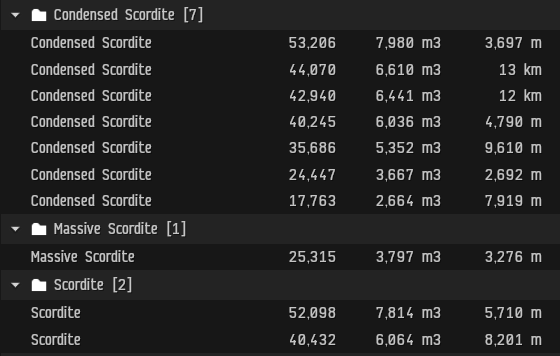

In [3]:
full_screen_image = get_screen()
full_screen_image.crop(get_survey_scan_results_box())

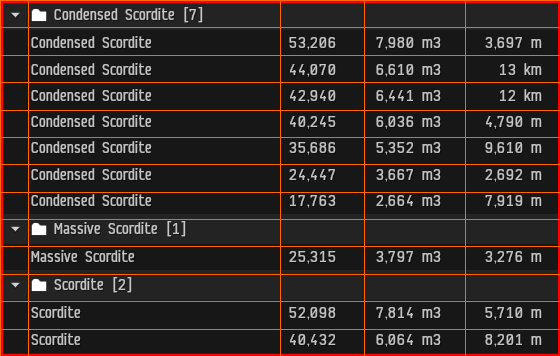

In [4]:
x_range = get_col_points()
y_range = get_row_points()

cells = get_cells(x_range, y_range)

img = render_outline(full_screen_image, x_range, y_range)
img.crop(get_survey_scan_results_box())

In [5]:
extract_values(img, cells, x_range, y_range)

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.61it/s]


,Locked,Ore,Quantity,Volume,Distance,click_target
0,,ondensed Scordite [7],,,,"(-600, 622)"
1,,Condensed Scordite,53206,7.988 m3,3697 m,"(-600, 649)"
2,,Condensed Scordite,44070,6618 m3,,"(-600, 677)"
3,,Condensed Scordite,42948,6.441 m3,12 km,"(-600, 704)"
4,,Condensed Scordite,40.245,6036 m3,4790 m,"(-600, 732)"
5,,Condensed Scordite,,5352 m3,9610 m,"(-600, 759)"
6,,Condensed Scordi,264467,,2692 m,"(-600, 786)"
7,,,17.763,,| 7919 m |,"(-600, 814)"
8,,Massive Scordite [1],,,,"(-600, 841)"
9,,,25315,,3276 m,"(-600, 868)"


In [6]:
def process():   
    img = get_screen()
    x_range = get_col_points()
    y_range = get_row_points()

    cells = get_cells(x_range, y_range)

    df = extract_values(img, cells, x_range, y_range)
    
    df.loc[df['Locked'] != '', 'Locked'] = '><'
    return df

# Models
https://github.com/tesseract-ocr/tessdata_best/blob/main/eng.traineddata  
C:\Program Files\Tesseract-OCR\tessdata

In [ ]:
time.sleep(0.5)

for l in range(100):
    print('checking...')
    df = process()
    snap_df = df[df['Quantity'].str.len()>0][0:2]
    snap_df = snap_df[~snap_df['Locked'].str.contains('><')]
    indicies = snap_df.index
    if len(indicies) == 2:
        print('starting 2x...')
        for i in indicies:
            pyautogui.moveTo(df.loc[i, 'click_target'])
            time.sleep(0.1)
            pyautogui.keyDown('ctrl')
            time.sleep(0.1)
            pyautogui.click()
            time.sleep(0.1)
            pyautogui.keyUp('ctrl')
            time.sleep(0.5)
        time.sleep(3)
        xy=None
        for i, index in enumerate(indicies):
            xy = df.loc[index, 'click_target']
            pyautogui.moveTo(xy)
            time.sleep(0.1)
            pyautogui.click()
            time.sleep(0.1)
            pyautogui.press(f'f{i + 1}')
            time.sleep(0.5)
        xy = (xy[0], xy[1]-200)
        pyautogui.moveTo(xy)
        print('started...')
        time.sleep(175)
    else:
        print('skipping...')
        time.sleep(10)

checking...


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.59it/s]


starting 2x...
started...
